In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(set(''.join(words)))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for c in w + ".":
            next_idx = stoi[c]
            X.append(context)
            Y.append(next_idx)
            context = context[1:] + [next_idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, Y_train = build_dataset(words[:n1])
X_val,   Y_val   = build_dataset(words[n1:n2])
X_test,  Y_test  = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
def cmp(s, dt, t):
    # Exact quality, approximate quality, largest difference
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_emb = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
# Layer 1
W1 = torch.randn((block_size * n_emb, n_hidden), generator=g) * (5/3) / ((block_size*n_emb)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size
ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [38]:
emb = C[Xb]
embact = emb.view(emb.shape[0], -1)
# Linear layer 1
hprebn = embact @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(n-1) * bndiff2.sum(dim=0, keepdim=True) # Bessel's correction: dividing by n-1
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2 # Output layer
# Cross entropy loss
logit_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logit_maxes # Subtract maxes for numerical stability
# End up exponetiating logits, if not norm logits, will cause numerical issue when too positive.
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv # !!! Shape is different. So broadcasting -> times. When a node is used several times, the gradients should be summed up.
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes,
         logits,
         h,
         hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani,
         hprebn,
         emb, embact]:
    t.retain_grad()
loss.backward()
loss

tensor(9.9316, grad_fn=<NegBackward0>)

In [ ]:
# Check shape first.
# If broadcasting, remeber to sum at the broadcasting dim.
# Remember chain rule.
# ...
emb = C[Xb]
dC = torch.zeros_like(C.shape)
# Traverse every element in Xb
for row in range(Xb.shape[0]):
    for column in range(Xb.shape[1]):
        row_of_C = Xb[row, column]
        C[row_of_C] += demb[row, column] #  The row of C might be used several times
# e.g. Xb. Column 1, 0, 14 have been used several times.
# tensor([[ 1,  1,  4],
#         [18, 14,  1],
#         [11,  5,  9],
#         [ 0,  0,  1],
#         [12, 15, 14]])

For bn layer
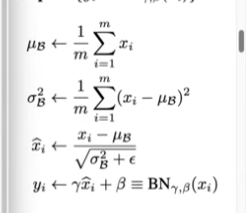

In [34]:
# For scrutinzing the shape
counts.shape, counts_sum_inv.shape, dcounts_sum.shape
logits.shape, logit_maxes.shape
h.shape, W2.shape, b2.shape, dlogits.shape
bngain.shape, bnraw.shape, bnbias.shape, dhpreact.shape
bndiff.shape, bnvar_inv.shape
bndiff.shape, bnmeani.shape, hprebn.shape
hprebn.shape, embact.shape, W1.shape, b1.shape
embact.shape, emb.shape
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [32]:
# Each of these integers will decide which row of C should be plucked out.
Xb[:5]

tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])

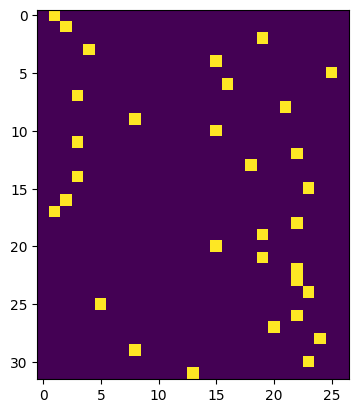

In [15]:
dlogit_maxes
plt.imshow(F.one_hot(logits.max(dim=1).indices, logits.shape[1]))

In [ ]:
# counts.sum(dim=1, keepdim=True) Helper
# a11 a12 a13 ---> b1 (= a11 + a12 + a13)
# a21 a22 a23 ---> b2 (= a21 + a22 + a23)
# a31 a32 a33 ---> b3 (= a31 + a32 + a33)

In [40]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1.0 / n

dprobs = (1.0 / probs) * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
dcounts = counts_sum_inv * dprobs # [32,1] * [32, 27]
dcounts_sum = -counts_sum**(-2) * dcounts_sum_inv
# counts depends on both 
dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = dcounts * counts
dlogits = dnorm_logits.clone()
# Logits maxes has been broadcast.
# As it's only used for numerical stability, gradients here are really small.
dlogit_maxes = -(dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(dim=1, keepdim=False).indices, logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0)
dhpreact = dh * (1 - h**2)
dbngain = (dhpreact * bnraw).sum(dim=0, keepdim=True)
dbnraw = dhpreact * bngain
dbnbias = dhpreact.sum(dim=0, keepdim=True)


dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (dbnraw * bndiff).sum(dim=0, keepdim=True)
dbnvar = dbnvar_inv * (-0.5 * (bnvar + 1e-5)**-1.5)
dbndiff2 = dbnvar * (1.0/(n-1)) * torch.ones_like(bndiff2)
dbndiff += 2 * bndiff * dbndiff2
dbnmeani = (dbndiff * -1.0).sum(dim=0)
dhprebn = dbndiff.clone()
dhprebn += dbnmeani * (1/n) * torch.ones_like(hprebn)

dembact = dhprebn @ W1.T
dW1 = embact.T @ dhprebn
db1 = dhprebn.sum(dim=0)

demb = dembact.view(emb.shape)

dC = torch.zeros_like(C)
# Traverse every element in Xb
for row in range(Xb.shape[0]):
    for column in range(Xb.shape[1]):
        row_of_C = Xb[row, column]
        dC[row_of_C] += demb[row, column] #  The row of C might be used several times
# e.g. Xb. Column 1, 0, 14 have been used several times.
# tensor([[ 1,  1,  4],
#         [18, 14,  1],
#         [11,  5,  9],
#         [ 0,  0,  1],
#         [12, 15, 14]])

cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bngain", dbngain, bngain)
cmp("bnraw", dbnraw, bnraw)
cmp("bnbias", dbnbias, bnbias)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)

cmp("bndiff2", dbndiff2, bndiff2)
cmp("bndiff", dbndiff, bndiff)
cmp("bnvar", dbnvar, bnvar)

cmp("bnmeani", dbnmeani, bnmeani)
cmp("hprebn", dhprebn, hprebn)

cmp("embact", dembact, embact)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)

cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: